# Análise SUS

Vamos analisar algumas das bases de dados presentes no site do DATASUS e levantar algumas hipóteses sobre elas e estudar como elas se relacionam umas com as outras.

Sempre será considerado o ano/mês de atendimento. 

## Importar as Bibliotecas

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import locale
from datetime import datetime

# formatar os números para mostrarem duas casa decimais
pd.options.display.float_format = '{:.2f}'.format

## Importar os Dados

Podemos abrir cada arquivo .csv em um leitor de texto qualquer para termos uma noção de qual valor utilizar nos parâmetros "skiprows" e "skipfooter". Mas nem sempre isso é possível de ser feito, em situações do dia-a-dia.

Dado | Descrição
:---|:---
Internações | Quantidade de AIH aprovadas no período, não considerando as de prorrogação (longa permanência). Este é um valor aproximado das internações, pois as transferências e reinternações estão aqui computadas.
Média de Permanência | Média de permanência das internações referentes às AIH aprovadas, computadas como internações, no período.
Óbitos | Quantidade de internações que tiveram alta por óbito, nas AIH aprovadas no período.
Taxa de Mortalidade | Razão entre a quantidade de óbitos e o número de AIH aprovadas, computadas como internações, no período, multiplicada por 100.
Valor Médio Internação | Valor Total dividido pela quantidade de Internações.



(\*) AIH - Autorização de Internação Hospitalar

### Internações

In [103]:
# importar o aquivo
internacoes = pd.read_csv('data/internacoes_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 12, thousands = '.', decimal = ',', engine = 'python')

In [104]:
internacoes.head(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,-,1,-,-,-,-,-,7,42,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
1,12 Acre,1,-,-,-,-,1,-,5,17,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
2,13 Amazonas,3,2,-,1,-,-,1,59,69,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


In [105]:
internacoes.tail(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
24,51 Mato Grosso,3,2,-,-,-,1,6,102,320,...,13666,13922,14257,14568,13946,13228,12207,10189,6787,2421359
25,52 Goiás,3,3,-,-,-,3,7,298,812,...,25576,25837,26288,26792,24894,23756,22425,18442,12400,4532259
26,53 Distrito Federal,4,12,1,-,1,1,9,47,281,...,16931,17705,17613,18395,17250,17473,17498,14852,11179,2559110


In [106]:
print('O dataframe \'internacoes\' possui {} linhas e {} colunas.'.format(internacoes.shape[0], internacoes.shape[1]))

O dataframe 'internacoes' possui 27 linhas e 173 colunas.


Como podemos ver acima, existem muitos valores faltantes no início do dataframe, pois os dados foram coletados a partir de 2008, e as colunas anteriores são valores adicionados retroativamente.

Vamos então remover as colunas que se encontram antes de Janeiro de 2008. Para isso vamos encontrar a localização dessa coluna para fazermos um slice.

In [107]:
print('A posição da coluna \'2008/Jan\' é a {}.'.format(internacoes.columns.get_loc('2008/Jan')))

A posição da coluna '2008/Jan' é a 13.


Vamos então remover as colunas antes da posição 13.

In [108]:
# cópia do dataframe original
interns = internacoes.copy()

In [109]:
# colocando a UF como indíce
interns = interns.set_index('Unidade da Federação').rename_axis(None)

In [110]:
# removendo as colunas (até a 12, pois tiramos uma coluna, a da UF)
interns = interns.drop(interns.columns[:12], axis = 1)

In [111]:
interns.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
11 Rondônia,5242,5562,5105,5175,5148,6099,7080,7332,6875,6907,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
12 Acre,3735,3723,4163,4223,4471,4478,4083,3823,4182,4141,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
13 Amazonas,13628,13828,14869,14323,14904,14578,14936,14413,13346,12602,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


Agora vamos conferir se temos algum outro valor faltante.

In [112]:
print('Agora o dataframe \'aih\' possui {} linhas e {} colunas.'.format(interns.shape[0], interns.shape[1]))

Agora o dataframe 'aih' possui 27 linhas e 160 colunas.


In [113]:
interns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 11 Rondônia to 53 Distrito Federal
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 34.0+ KB


Utilizando o ```.info()``` acima vemos que todas as 160 colunas são do tipo ```int64```, então não temos nenhum valor como "-" ou "...", pois, caso tivéssemos, a coluna seria do tipo ```object```. 

Quando necessário, irei adicionar uma coluna com as siglas dos estados, para que possamos ter uma melhor visualização nos gráficos.

In [114]:
siglas = ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL',
          'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC', 'RS', 'MS', 'MT', 'GO', 'DF']

interns_sig = interns.copy()
interns_sig['Siglas'] = siglas
interns_sig = interns_sig.set_index('Siglas').rename_axis(None)
interns_sig = interns_sig.sort_values(by = 'Total', ascending = False)

Vamos então fazer algumas visualizações gráficas.

In [115]:
# mudar o idioma para convertermos as colunas para data
locale.setlocale(locale.LC_ALL , 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [116]:
interns_sig = interns_sig.drop('Total', axis = 1)
interns_sig.columns = pd.to_datetime(interns_sig.columns, format='%Y/%b')

### Graficamente

In [117]:
# separar por regiões

norte = interns.index[:7].tolist()
nordeste = interns.index[7:16].tolist()
sudeste = interns.index[16:20].tolist()
sul = interns.index[20:23].tolist()
centro_oeste = interns.index[23:].tolist()

In [118]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

In [119]:
internas = interns.copy()
internas = internas.sort_values(by = 'Total', ascending = False)
internas = internas.drop('Total', axis = 1)
internas.columns = pd.to_datetime(internas.columns, format='%Y/%b')

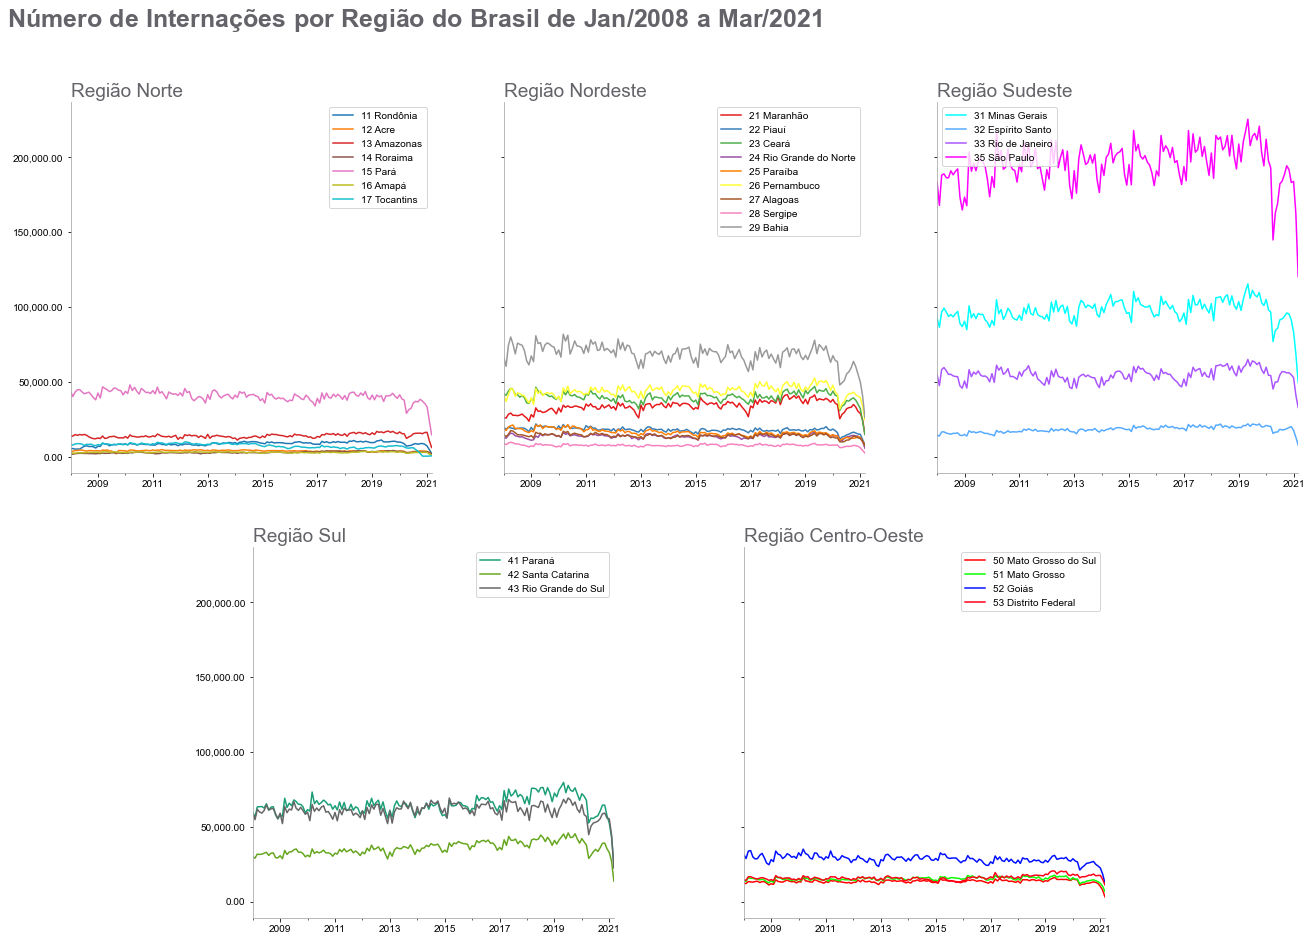

In [120]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (22, 15))

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

axes[1, 2].set_visible(False)

internas.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

internas.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'Set1')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

internas.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'cool')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

internas.loc[sul].T.plot(ax = axes[1, 0], colormap = 'Dark2')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

internas.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'hsv')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1, 0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1, 1].set_position([0.55, 0.125, 0.228, 0.343])

# plt.savefig('estados.jpg')

plt.show()

Aparentemente está tudo certo com os valores, não temos nada muito distante dos demais.

Algumas observações que tiramos desse gráfico "feio":
- Há uma sazonalidade no número de internações
    - Iremos observar melhor a seguir em quais períodos as altas e baixas acontecem
- Embora exista uma tendência de queda, ela é muito pouca e há uma certa estabilidade nos valores
    - Também iremos analisar isso melhor a seguir
- Há uma queda de internações nos últimos meses?
    - Essa queda que existe no final do gráfico deve-se ao fato do ano ainda não estar terminado, então os valores ainda não estão todos colocados para esse período. Podemos remover esses valores ou deixar como está. Optei por deixar do jeito que está.

In [121]:
internas = internas.T

In [122]:
internas.head()

,35 São Paulo,31 Minas Gerais,29 Bahia,41 Paraná,43 Rio Grande do Sul,33 Rio de Janeiro,26 Pernambuco,15 Pará,23 Ceará,42 Santa Catarina,...,13 Amazonas,27 Alagoas,24 Rio Grande do Norte,50 Mato Grosso do Sul,11 Rondônia,28 Sergipe,17 Tocantins,12 Acre,16 Amapá,14 Roraima
2008-01-01,183408,92681,66223,60003,58910,54995,40916,43817,41997,29970,...,13628,14837,12773,12254,5242,8731,8294,3735,2721,1898
2008-02-01,167955,86508,60453,56290,54736,47536,36866,40225,41110,29011,...,13828,13445,12423,12062,5562,8119,7846,3723,2511,1739
2008-03-01,188153,96745,74394,63308,61611,58293,41469,43274,43877,31710,...,14869,14959,14359,13397,5105,9162,8562,4163,2390,2047
2008-04-01,188980,99252,80024,63368,59890,59623,45686,44734,45769,31495,...,14323,17517,15815,13124,5175,9738,8793,4223,2663,2211
2008-05-01,186439,96742,75255,63544,59106,57523,44966,44894,44941,31708,...,14904,17140,15456,12990,5148,9324,8751,4471,2740,2415


In [123]:
internas['Nordeste'] = internas[nordeste].sum(axis = 1)
internas['Norte'] = internas[norte].sum(axis = 1)
internas['Sudeste'] = internas[sudeste].sum(axis = 1)
internas['Sul'] = internas[sul].sum(axis = 1)
internas['Centro_Oeste'] = internas[centro_oeste].sum(axis = 1)

internas = internas[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

internas.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,249736,79335,345600,148883,72260
2008-02-01,234262,75434,315847,140037,68557
2008-03-01,266151,80410,359802,156629,79740
2008-04-01,283801,82122,364509,154753,79269
2008-05-01,274964,83323,356554,154358,74318


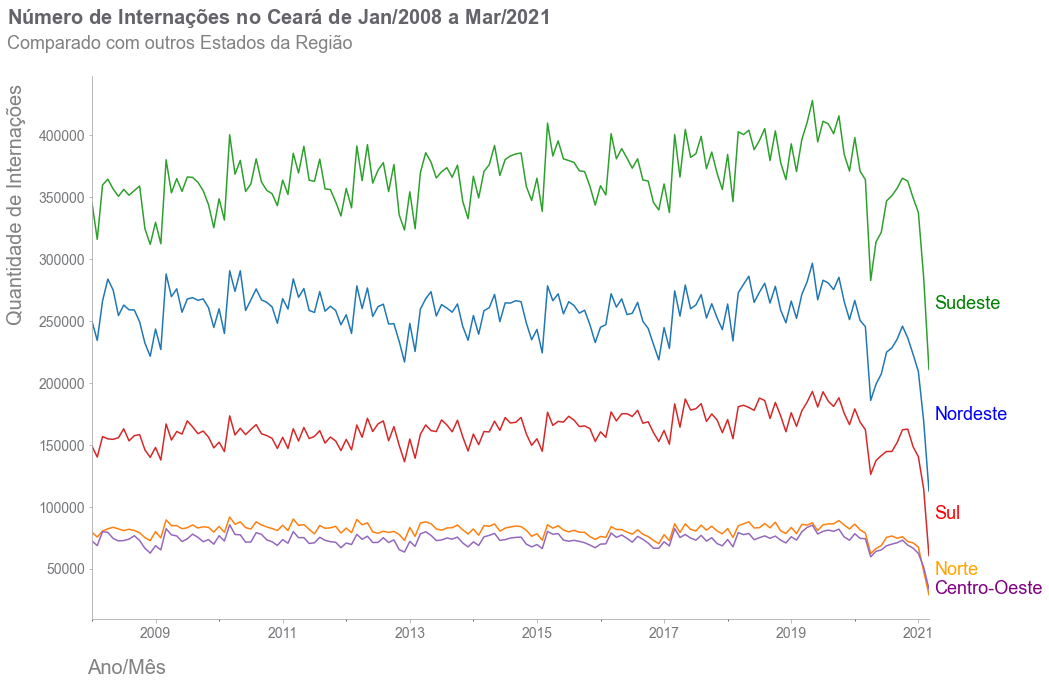

In [124]:
#ax = plt.figure(figsize = (18, 12))

ax = internas.plot(figsize = (15, 10))

ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(440, 490000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 20, color = GRAY4)
plt.text(440, 470000, 'Comparado com outros Estados da Região',
         fontsize = 18, color = GRAY6)

plt.text(440, 250000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -35000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 260000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 170000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 90000, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 45000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 30000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

In [125]:
internacoes_nordeste = interns.loc[nordeste].sort_values(by = 'Total', ascending = False)
internacoes_nordeste = internacoes_nordeste.drop('Total', axis = 1)
internacoes_nordeste.columns = pd.to_datetime(internacoes_nordeste.columns, format='%Y/%b')

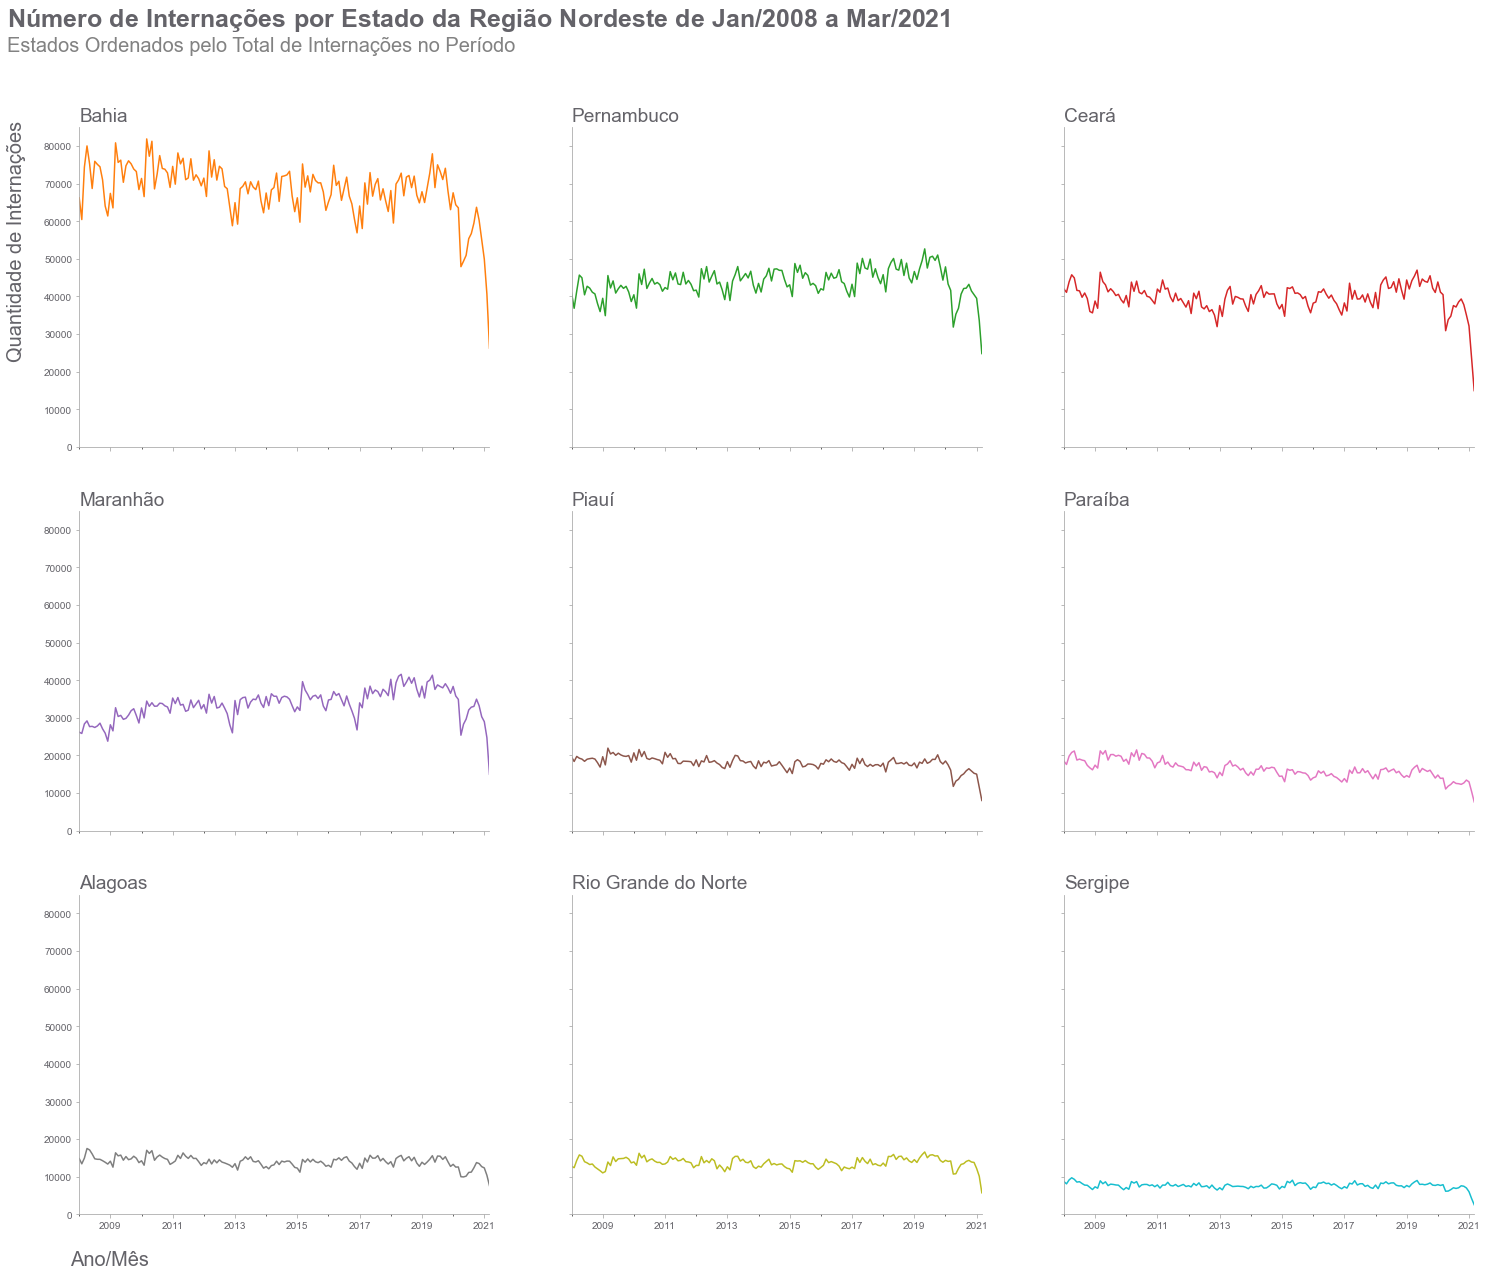

In [126]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.085, 0.933, 'Estados Ordenados pelo Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.085, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in internacoes_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = internacoes_nordeste.loc[estado].T.plot(color = palette(num))
    plt.ylim(0,85000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado[3:], loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey')
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()

Com isso, vemos que os três estados do Nordeste que mais tiveram internações de Janeiro de 2008 a Março de 2021 foram Bahia, Pernambuco e Ceará. A quantidade de internações manteve-se quase que estável, se não considerarmos o ano de 2021, pois os dados ainda não estão completos.

Analisando agora apenas o estado do Ceará.

In [127]:
internacoes_ceara = internacoes_nordeste.loc['23 Ceará']

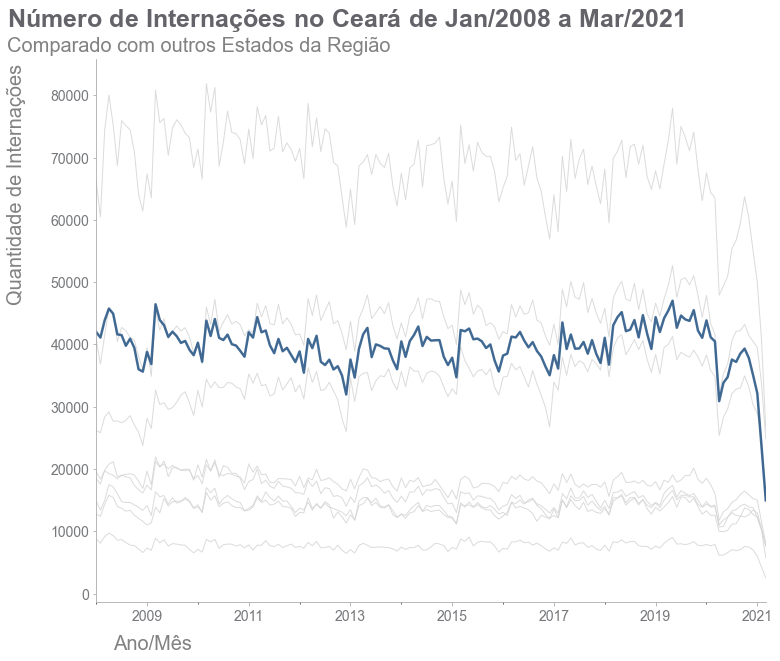

In [128]:
plt.figure(figsize = (12, 10))

for estado in internacoes_nordeste.index.tolist():
    ax = internacoes_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = internacoes_nordeste.loc['23 Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(435, 90999, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(435, 86999, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(435, 47000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(460, -9000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.show()

Novamente não considerando os últimos meses por não estarem totalmente atualizados, percebemos que as internações mantém certa estabilidade ao passar dos anos, mas também notamos que existem períodos de alta e baixa, e uma sazonalidade.

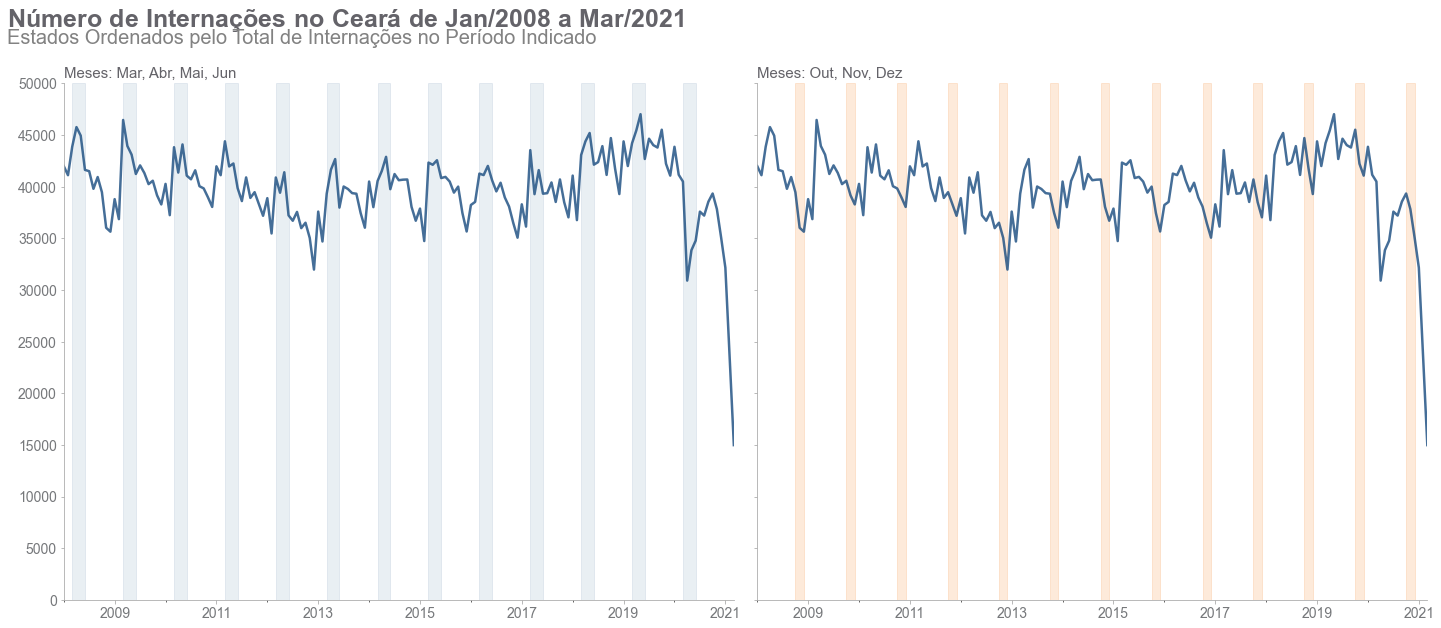

In [129]:
fig, axes = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (20, 8))

fig.text(0, 1.05, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

fig.text(0, 1.02, 'Estados Ordenados pelo Total de Internações no Período Indicado',
         fontsize = 20, color = GRAY6)

#fig.text(0.085, 0.71, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
#fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[0], color = BLUE1, linewidth = 2.5, alpha = 0.8)
internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[1], color = BLUE1, linewidth = 2.5, alpha = 0.8)

plt.ylim(0, 50000)
axes[0].set_yticks(range(0, 50001, 5000))

for i in [0, 1]:
    axes[i].tick_params(color = 'darkgrey')
    axes[i].spines['bottom'].set_color('darkgrey')
    axes[i].spines['left'].set_color('darkgrey')
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    for k in axes[i].get_yticklabels() + axes[i].get_xticklabels():
        k.set_fontsize(14)
        k.set_color(GRAY5)

#for mes in range(0, 160, 12):
#    axes[0].axvspan(mes + 2, mes + 5, alpha = 0.2, facecolor = BLUE4)
    
#for mes in range(0, 160, 12):
#    axes[1].axvspan(mes + 9, mes + 12, alpha = 0.2, facecolor = ORANGE1)

anos = []
for valor in range(2008, 2022):
    anos.append(valor)

for ano in range(len(anos)):
    axes[0].axvspan(datetime(anos[ano],3,1), datetime(anos[ano],6,1), color = BLUE4, alpha = 0.2)
    axes[1].axvspan(datetime(anos[ano],10,1), datetime(anos[ano],12,1), color = ORANGE1, alpha = 0.2)
    

axes[0].set_title('Meses: Mar, Abr, Mai, Jun', loc = 'left', fontsize = 15, color = GRAY4)
axes[1].set_title('Meses: Out, Nov, Dez', loc = 'left', fontsize = 15, color = GRAY4)

fig.tight_layout()
    
plt.show()

Novamente desconsiderando o período dos anos de 2020 e 2021 por estarem incompletos, observamos que as altas de internações ocorrem nos meses . . . 

In [130]:
internacoes_nordeste[:125].T.mean()[2]

39763.157232704405

In [131]:
internacoes_nordeste[internacoes_nordeste.columns[:144]].T.mean()

29 Bahia                 69863.02
26 Pernambuco            44355.60
23 Ceará                 40284.90
21 Maranhão              33972.97
22 Piauí                 18342.48
25 Paraíba               16678.94
27 Alagoas               14285.56
24 Rio Grande do Norte   13852.40
28 Sergipe                7784.01
dtype: float64

### Internações por Município do Ceará, levando em conta o local de internação

Vamos agora comparar o número de internações no Ceará, focando em Fortaleza, e comparando a capital com os demais municícpios do Estado.

Aqui vale uma ressalva:

Para analisar esse dado, existe a opção de contabilizar o município onde o paciente foi internado, ou o município onde o paciente reside. Esses dois casos nem sempre dão os mesmos valores, pois muitas vezes pessoas que residem em municípios menos favorecidos, internam-se na capital, pois é onde estão grande parte dos hospitais.

Faremos uma breve comparação desses dois casos para vermos se existe mesmo uma grande disparidade entre esses dados.

In [132]:
# número de internações por município do Ceará por local de internação
intern_munic_local_raw = pd.read_csv('data/intern_muni_ce_por_local_de_internacao.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [133]:
intern_munic_local_raw.head(3)

,Município,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230020 Acaraú,-,-,-,-,-,-,2,22,218,...,223,182,247,254,337,344,312,-,-,48329
1,230030 Acopiara,-,-,-,2,-,2,4,12,329,...,99,219,159,221,148,77,97,112,109,25017
2,230040 Aiuaba,-,-,-,-,-,-,1,10,16,...,23,13,16,16,15,5,-,-,-,1733


Vamos limpar um pouco esses dados.

In [134]:
# cópia do dataframe original
intern_munic_local = intern_munic_local_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_local['Município'] = intern_munic_local['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_local = intern_munic_local.set_index('Município').rename_axis(None)

intern_munic_local.columns

Index(['2007/Jan', '2007/Fev', '2007/Jul', '2007/Ago', '2007/Set', '2007/Out',
       '2007/Nov', '2007/Dez', '2008/Jan', '2008/Fev',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=168)

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [135]:
intern_munic_local = intern_munic_local[intern_munic_local.columns[8:]]
intern_munic_local.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,218,303,304,307,289,277,272,223,278,214,...,223,182,247,254,337,344,312,-,-,48329
Acopiara,329,378,320,277,268,254,228,284,241,228,...,99,219,159,221,148,77,97,112,109,25017
Aiuaba,16,13,15,8,8,7,13,13,14,10,...,23,13,16,16,15,5,-,-,-,1733


In [136]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(1), object(159)
memory usage: 216.3+ KB


Temos 159 colunas do tipo ```object```.

Já sabemos pelo site que o hífen nos dados equivale a _"Dado numérico igual a 0 não resultante de arredondamento."_

Vamos então fazer a substituição.

In [137]:
intern_munic_local = intern_munic_local.replace('-', 0)

In [138]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(1), object(159)
memory usage: 216.3+ KB


Mesmo realizando a substituição por zero, as colunas continuaram como ```object```. Vamos forçá-las a virarem do tipo numérico.

In [139]:
intern_munic_local = intern_munic_local.apply(pd.to_numeric, errors = 'coerce')

In [140]:
intern_munic_local.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 216.3+ KB


Agora sim, todas as nossas colunas estão como ```int64``` e podemos analisá-las.

In [141]:
intern_munic_local.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

Temos uma coluna 'Total'. Vamos removê-la e, caso necessário, podemos somar novamente os valores para obtê-la.

In [142]:
intern_munic_local = intern_munic_local.drop('Total', axis = 1)

Como queremos analisar e comparar Fortaleza com todos os outros municípios do Estado, precisamos apenas dos dados de Fortaleza e iremos juntar os dados dos outros municípios em um só.

In [143]:
intern_munic_local.head()

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar
Acaraú,218,303,304,307,289,277,272,223,278,214,...,178,223,182,247,254,337,344,312,0,0
Acopiara,329,378,320,277,268,254,228,284,241,228,...,93,99,219,159,221,148,77,97,112,109
Aiuaba,16,13,15,8,8,7,13,13,14,10,...,23,23,13,16,16,15,5,0,0,0
Altaneira,17,17,15,17,12,11,11,12,18,23,...,12,4,12,16,11,3,0,0,0,0
Alto Santo,47,55,66,75,62,55,62,53,62,61,...,12,6,11,14,9,3,3,3,10,7


Para isso, podemos somar todos as colunas de todos os municípios exceto Fortaleza.

In [144]:
# convertendo o "Ano/Mês" para datetime
intern_munic_local.columns = pd.to_datetime(intern_munic_local.columns, format='%Y/%b')

In [145]:
intern_munic_local = intern_munic_local.T

In [146]:
intern_munic_local['Soma'] = intern_munic_local.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [147]:
intern_munic_local = intern_munic_local[['Fortaleza', 'Soma']]

In [148]:
intern_munic_local

,Fortaleza,Soma
2008-01-01,17515,24482
2008-02-01,15720,25390
2008-03-01,16599,27278
2008-04-01,17810,27959
2008-05-01,18351,26590
...,...,...
2020-11-01,16660,21170
2020-12-01,16104,18973
2021-01-01,14493,17664
2021-02-01,9943,13616


Agora temos um dataframe com apenas duas colunas, uma correspondendo à Fortaleza e outra correnspondendo à soma de todos os outros municípios.

Vamos analisar graficamente.

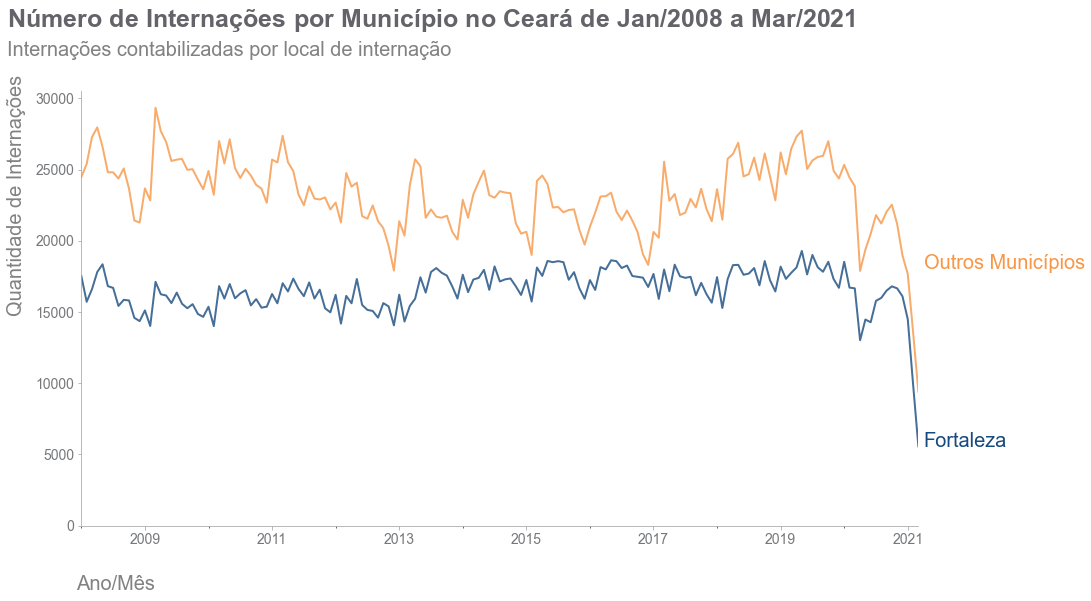

In [149]:
color = [BLUE1, ORANGE1]

ax = intern_munic_local.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 30001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 35000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 33000, 'Internações contabilizadas por local de internação',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4500, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

### Internações por Município do Ceará, levando em conta o local de residência

In [150]:
# número de internações por município do Ceará por local de residência
intern_munic_resid_raw = pd.read_csv('data/intern_muni_ce_por_local_de_residencia.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [151]:
intern_munic_resid_raw.head(3)

,Município,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,2007/Nov,2007/Dez,2008/Jan,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230010 Abaiara,-,-,-,-,1,2,7,9,33,...,21,31,33,35,24,25,23,6,6,6392
1,230015 Acarape,-,-,-,-,3,2,3,15,81,...,78,51,34,53,58,50,58,36,14,9966
2,230020 Acaraú,-,-,-,-,1,6,19,76,289,...,216,176,169,240,291,270,207,31,11,41614


Vamos limpar um pouco esses dados.

In [152]:
# cópia do dataframe original
intern_munic_resid = intern_munic_resid_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_resid['Município'] = intern_munic_resid['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_resid = intern_munic_resid.set_index('Município').rename_axis(None)

intern_munic_resid.columns

Index(['2007/Jan', '2007/Fev', '2007/Jul', '2007/Ago', '2007/Set', '2007/Out',
       '2007/Nov', '2007/Dez', '2008/Jan', '2008/Fev',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=168)

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [153]:
intern_munic_resid = intern_munic_resid[intern_munic_resid.columns[8:]]
intern_munic_resid.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Abaiara,33,47,47,39,33,32,50,46,45,53,...,21,31,33,35,24,25,23,6,6,6392
Acarape,81,62,75,62,79,44,51,43,64,44,...,78,51,34,53,58,50,58,36,14,9966
Acaraú,289,334,313,318,306,282,274,248,310,270,...,216,176,169,240,291,270,207,31,11,41614


In [154]:
intern_munic_resid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, Abaiara to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(159), object(1)
memory usage: 231.4+ KB


Aqui temos apenas uma coluna do tipo ```object```. Vamos encontrá-la.

In [155]:
intern_munic_resid.select_dtypes(object).head()

,2021/Mar
Abaiara,6
Acarape,14
Acaraú,11
Acopiara,95
Aiuaba,27


Então provavelmente temos algum valor faltante na coluna '2021/Mar'. Isso condiz com o que viemos falando até aqui, que os valores dos últimos meses ainda não estão completos.

In [156]:
intern_munic_resid = intern_munic_resid.replace('-', 0)

In [157]:
intern_munic_resid['2021/Mar'] = intern_munic_resid['2021/Mar'].astype('int64')

In [158]:
intern_munic_resid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, Abaiara to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 231.4+ KB


Agora temos todas as colunas do tipo ```int64```.

In [159]:
intern_munic_resid.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

Ainda temos uma coluna 'Total', iremos removê-la.

In [160]:
intern_munic_resid = intern_munic_resid.drop('Total', axis = 1)

Agora só nos resta separar o dataframe em duas colunas: Fortaleza e Outros Municípios.

In [161]:
# convertendo o "Ano/Mês" para datetime
intern_munic_resid.columns = pd.to_datetime(intern_munic_resid.columns, format='%Y/%b')

In [162]:
intern_munic_resid = intern_munic_resid.T

In [163]:
intern_munic_resid['Soma'] = intern_munic_resid.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [164]:
intern_munic_resid = intern_munic_resid[['Fortaleza', 'Soma']]

In [165]:
intern_munic_local

,Fortaleza,Soma
2008-01-01,17515,24482
2008-02-01,15720,25390
2008-03-01,16599,27278
2008-04-01,17810,27959
2008-05-01,18351,26590
...,...,...
2020-11-01,16660,21170
2020-12-01,16104,18973
2021-01-01,14493,17664
2021-02-01,9943,13616


Pronto, já temos o que queríamos e podemos analisar graficamente.

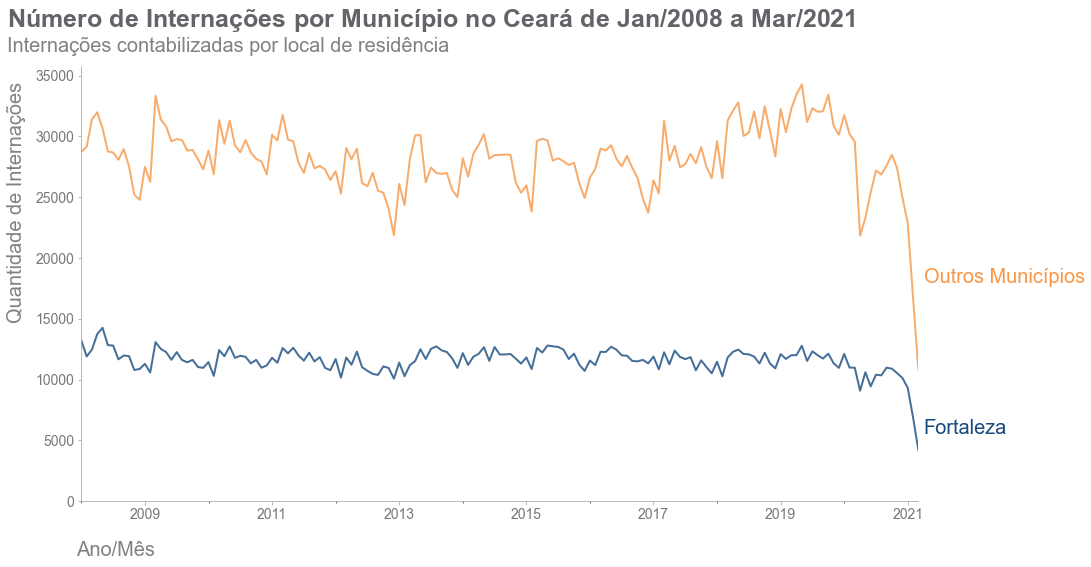

In [166]:
color = [BLUE1, ORANGE1]

ax = intern_munic_resid.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 35001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 39000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 37000, 'Internações contabilizadas por local de residência',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4500, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

Aqui a diferença é maior, pois local de residência . . .

## Conclusão

Região que mais gasta... porcentagens?

Estado do Nordeste que mais gasta... porcentagens?

Cidade do Ceará que mais gasta... porcentagens?


## Gastos

Agora vamos avaliar e analisar o valor total utilizado por internações para vermos se há alguma relação com o número de internações de cada local.

In [167]:
valor_total_br = pd.read_csv('data/valor_total_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [168]:
valor_total_br.head(3)

,Unidade da Federação,1992/Mar,1992/Abr,1993/Mai,1993/Dez,1994/Jan,1994/Fev,1994/Mai,1994/Ago,1994/Nov,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,-,-,-,-,-,-,-,-,-,...,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04,996411254.68
1,12 Acre,-,-,-,-,-,-,-,-,-,...,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65,450048530.47
2,13 Amazonas,-,-,-,-,-,-,-,-,-,...,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80,1917247936.05


Hora de limpar esses dados!

In [169]:
# cópia do dataframe original
valortotalbr = valor_total_br.copy()

# remover os números dos nomes das UFs
# podemos fazer isso pois usamos outro método pra separar por regiões
valortotalbr['Unidade da Federação'] = valortotalbr['Unidade da Federação'].str[3:]

# colocando a coluna de UFs como índice
valortotalbr = valortotalbr.set_index('Unidade da Federação').rename_axis(None)

Vamos encontrar em qual posição está a coluna '2008/Jan' e fazer um slice para nosso dataframe iniciar a partir dela.

In [170]:
valortotalbr.columns.get_loc('2008/Jan')

126

In [171]:
# fazendo o slicing
valortotalbr = valortotalbr[valortotalbr.columns[126:]]

In [172]:
valortotalbr.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Rondônia,1829559.71,1940792.63,1955721.68,2143353.81,2280382.58,2624542.97,2973421.02,2938286.29,2843930.91,2878153.20,...,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04,996411254.68
Acre,1731744.62,1743978.66,2057439.02,2057829.69,2226577.93,2112576.82,2029128.01,1886871.84,2084884.80,2230838.45,...,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65,450048530.47
Amazonas,11419210.08,7934652.10,8641517.13,8531576.49,9079902.15,8646295.77,8755806.50,8331763.97,8148089.92,7681661.02,...,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80,1917247936.05


Será que todos os valores estão completos? Vamos conferir!

In [173]:
valortotalbr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, Rondônia to Goiás
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 32.7+ KB


Todas as colunas são do tipo ```float64```, então não temos nenhum valor que foi subsituído por hífen ou algo do tipo. Ainda bem!

Vamos remover a coluna 'Total'. Caso precisemos do total dos valores, podemos facilmente somá-los.

In [174]:
valortotalbr = valortotalbr.drop('Total', axis = 1)

Finalmente, vamos converter as colunas para o formato de data.

In [175]:
valortotalbr.columns = pd.to_datetime(valortotalbr.columns, format = '%Y/%b')

In [176]:
valortotalbr.head(3)

,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,...,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01
Rondônia,1829559.71,1940792.63,1955721.68,2143353.81,2280382.58,2624542.97,2973421.02,2938286.29,2843930.91,2878153.20,...,10993332.84,10479989.36,11433467.56,8876900.39,8167253.19,8759013.71,9003402.23,8414690.60,6039419.59,4732441.04
Acre,1731744.62,1743978.66,2057439.02,2057829.69,2226577.93,2112576.82,2029128.01,1886871.84,2084884.80,2230838.45,...,3914823.86,4053085.41,3658265.59,3470409.45,3267918.69,3393958.27,3711660.71,3005561.16,2272733.90,1137341.65
Amazonas,11419210.08,7934652.10,8641517.13,8531576.49,9079902.15,8646295.77,8755806.50,8331763.97,8148089.92,7681661.02,...,18433057.47,19303743.16,18687233.58,18628627.49,18728251.20,20451573.77,21546059.48,24439059.57,13679358.06,6799060.80


Agora parece que está tudo certo e podemos começar a analisar graficamente.

In [177]:
# separar por regiões

norte = valortotalbr.index[:7].tolist()
nordeste = valortotalbr.index[7:16].tolist()
sudeste = valortotalbr.index[16:20].tolist()
sul = valortotalbr.index[20:23].tolist()
centro_oeste = valortotalbr.index[23:].tolist()

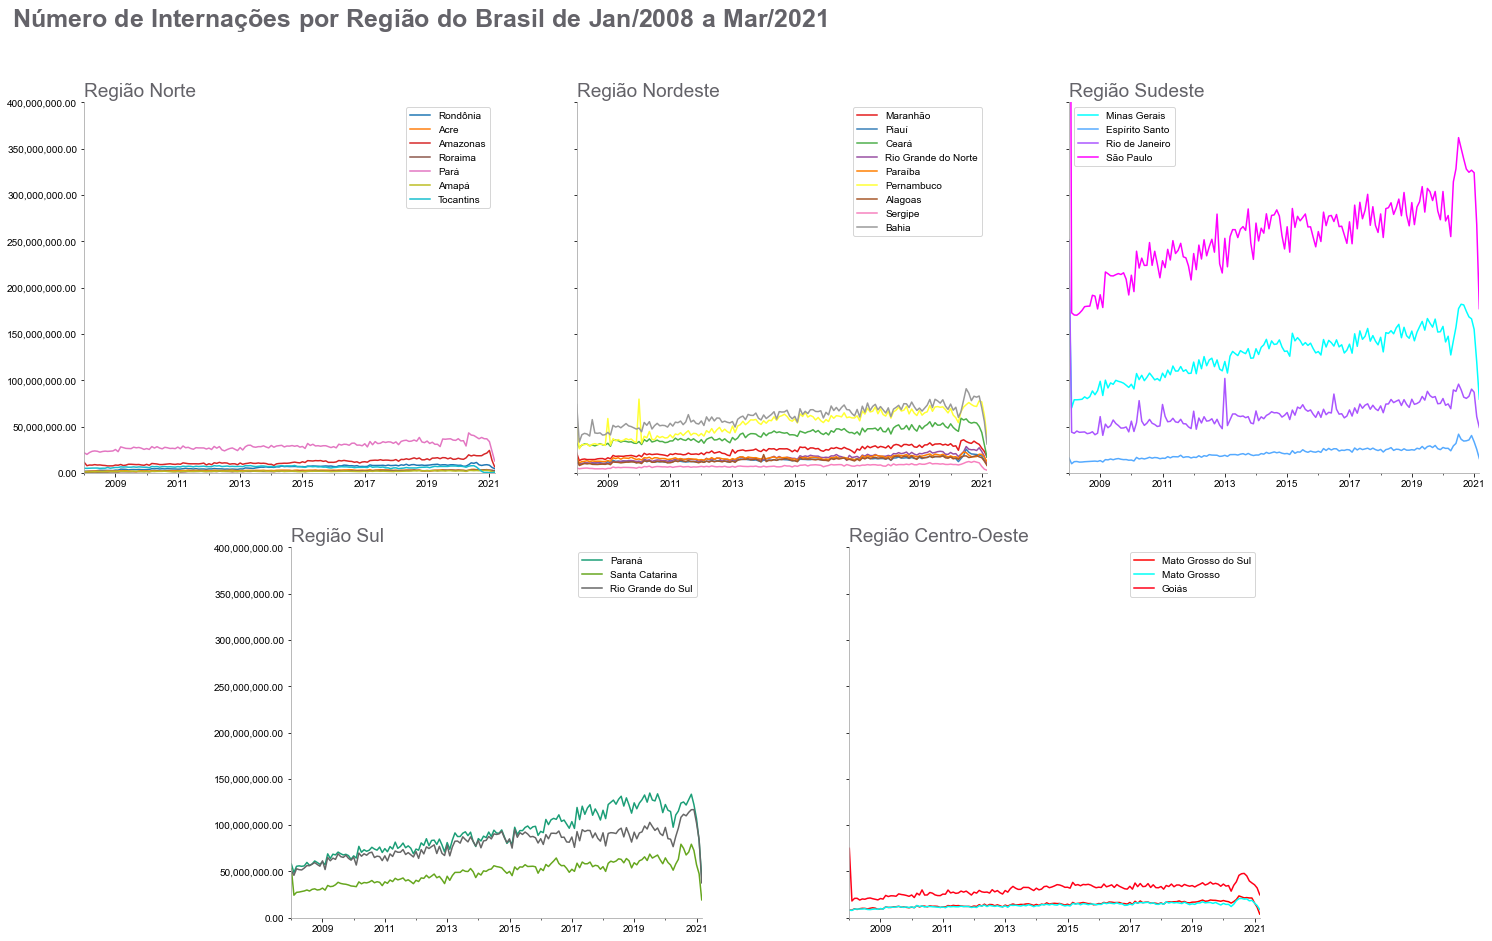

In [182]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (25, 15))

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 400000000)

axes[1, 2].set_visible(False)

valortotalbr.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

valortotalbr.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'Set1')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

valortotalbr.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'cool')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

valortotalbr.loc[sul].T.plot(ax = axes[1, 0], colormap = 'Dark2')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

valortotalbr.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'hsv')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

Conclusões: . . .

Vamos agora ver o total por região.

In [183]:
valor_total_regioes = valortotalbr.copy()
valor_total_regioes = valor_total_regioes.T

valor_total_regioes['Nordeste'] = valor_total_regioes[nordeste].sum(axis = 1)
valor_total_regioes['Norte'] = valor_total_regioes[norte].sum(axis = 1)
valor_total_regioes['Sudeste'] = valor_total_regioes[sudeste].sum(axis = 1)
valor_total_regioes['Sul'] = valor_total_regioes[sul].sum(axis = 1)
valor_total_regioes['Centro_Oeste'] = valor_total_regioes[centro_oeste].sum(axis = 1)

valor_total_regioes = valor_total_regioes[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

valor_total_regioes.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,240952019.39,44017418.18,1511999605.49,162180329.15,91553458.20
2008-02-01,143170221.70,38844188.02,297424135.24,119162324.20,34358557.99
2008-03-01,164001219.48,42058042.63,304838597.77,136023967.49,40202469.49
2008-04-01,169546980.47,43806481.51,307144452.15,135894194.03,39437608.08
2008-05-01,169304560.50,45231240.95,307471263.54,135608462.24,38382852.63


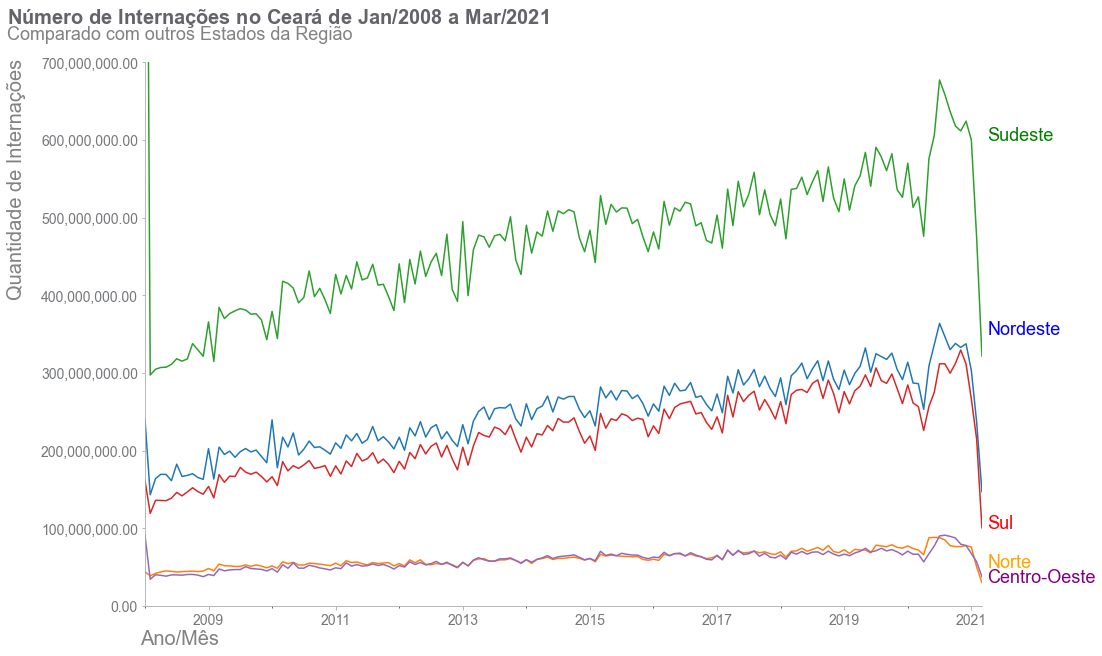

In [184]:
ax = valor_total_regioes.plot(figsize = (15, 10))

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 700000000)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(430, 750000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 20, color = GRAY4)
plt.text(430, 730000000, 'Comparado com outros Estados da Região',
         fontsize = 18, color = GRAY6)

plt.text(430, 400000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -50000000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 600000000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 350000000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 100000000, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 50000000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 30000000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

Conclusões: . . .

os valores de norte e centro-oeste são extremamente parecidos!

In [185]:
valor_total_nordeste = valortotalbr.copy()

valor_total_nordeste = valor_total_nordeste.loc[nordeste]

valor_total_nordeste['Soma'] = valor_total_nordeste.sum(axis = 1)

valor_total_nordeste = valor_total_nordeste.sort_values(by = 'Soma', ascending = False)

valor_total_nordeste = valor_total_nordeste.drop('Soma', axis = 1)

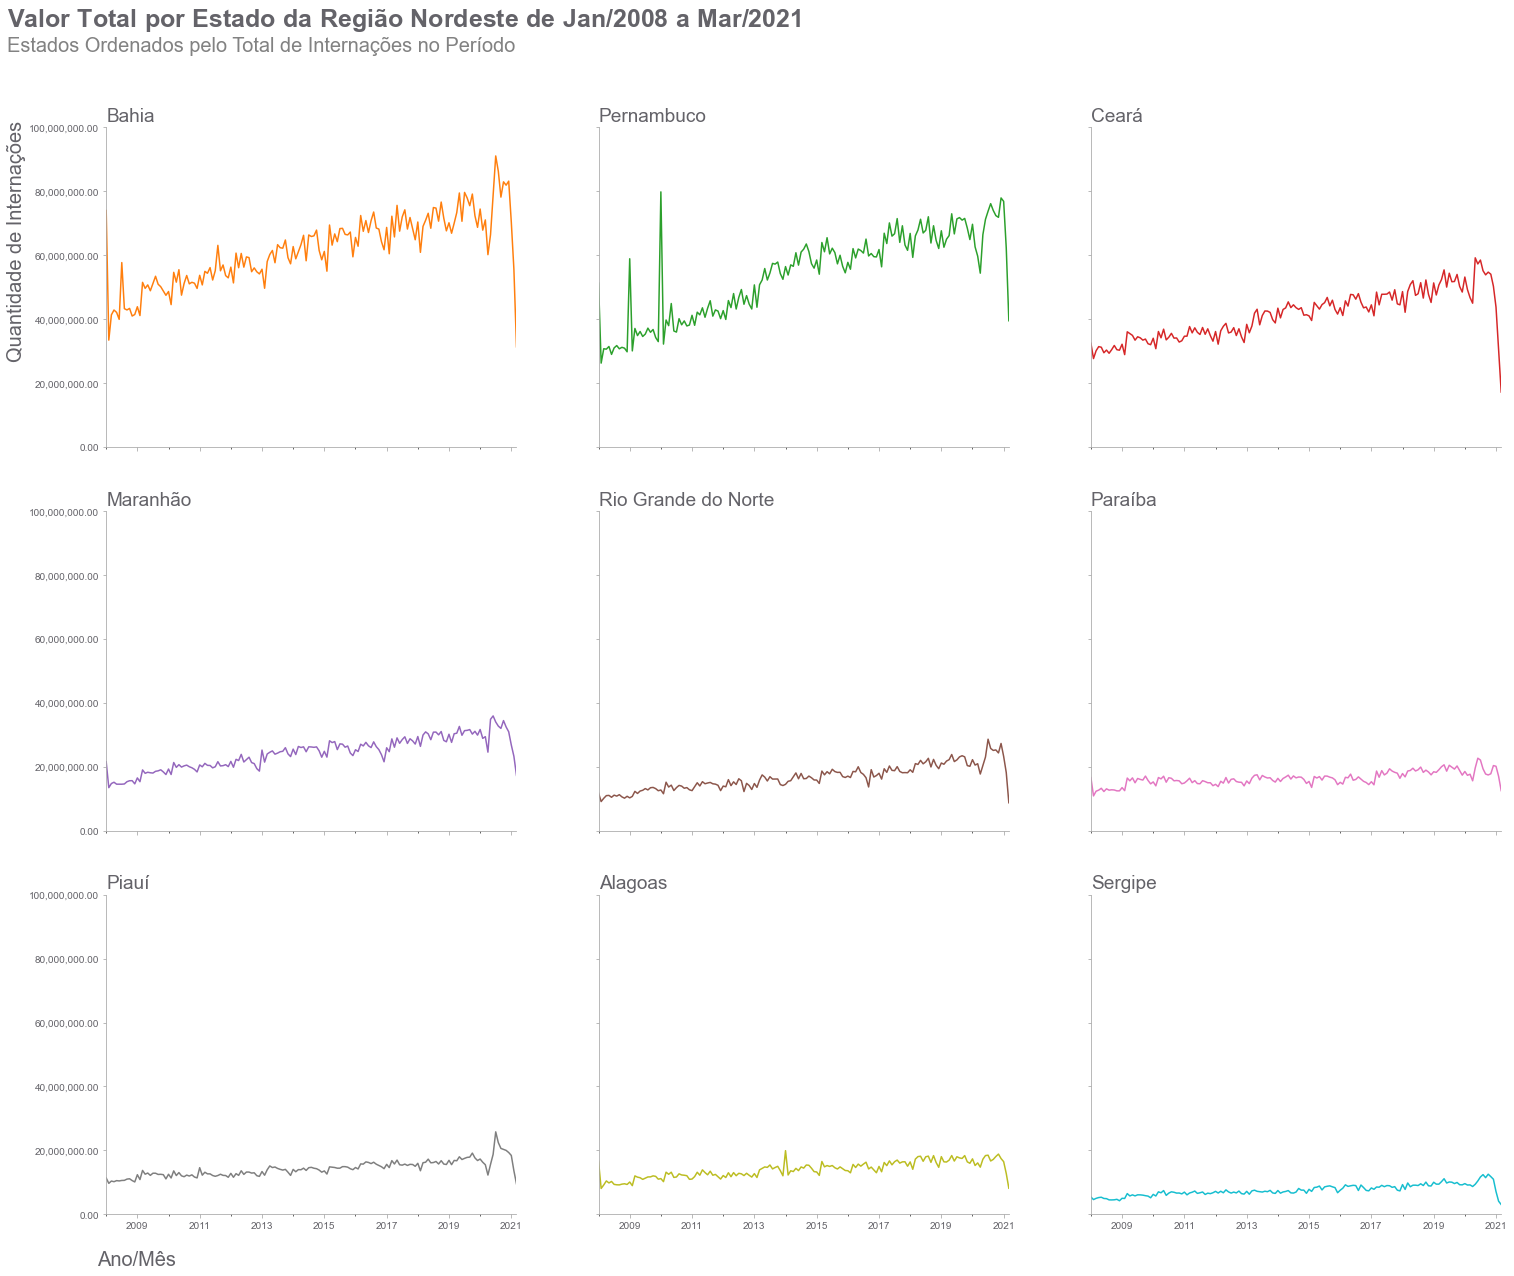

In [186]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.070, 0.95, '$\\bf{Valor\ Total\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.070, 0.933, 'Estados Ordenados pelo Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.070, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in valor_total_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = valor_total_nordeste.loc[estado].T.plot(color = palette(num))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.ylim(0, 100000000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado, loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey', bottom = True)
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#plt.suptitle("Número de Internações por Estado da Região Nordeste de Jan/2008 a Mar/2021\nOrdenados pelo Total de Gastos",
#             fontsize = 20, fontweight = 5, color = GRAY4, style = 'italic', y = 0.95, x = 0.1, ha = 'left')

plt.show()

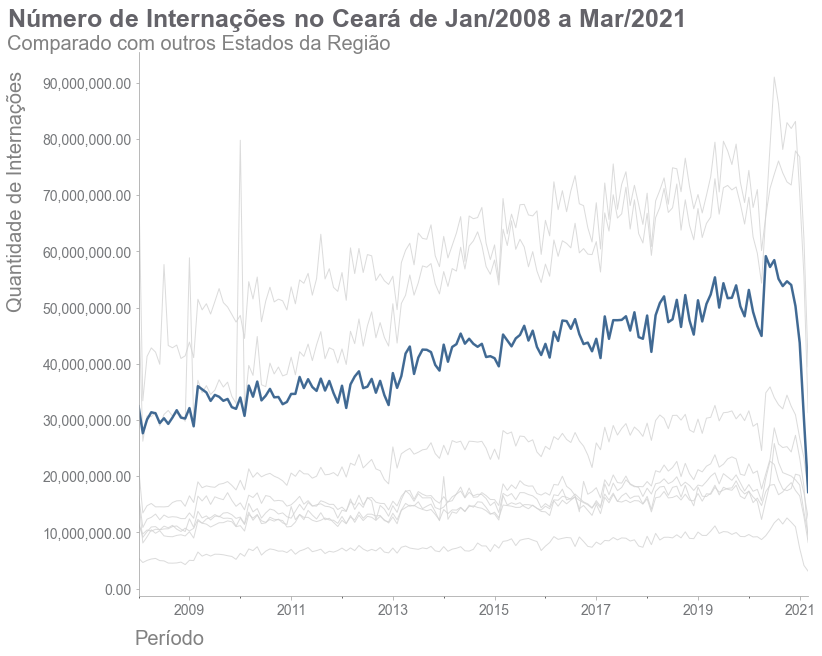

In [201]:
plt.figure(figsize = (12, 10))

for estado in valor_total_nordeste.index.tolist():
    ax = valor_total_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = valor_total_nordeste.loc['Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 90000001, 10000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(425, 100000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(425, 96000000, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(425, 50000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -10000000, 'Período', fontsize = 20, color = GRAY6)

plt.show()

### Valor Total por Município do Ceará

In [202]:
valor_total_municipios_ceara = pd.read_csv('data/valor_total_municipios_ceara.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [203]:
valor_total_municipios_ceara.head(3)

,Município,2000/Fev,2000/Nov,2003/Jan,2005/Fev,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,230020 Acaraú,-,-,-,-,-,-,-,-,-,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
1,230030 Acopiara,-,-,-,-,-,-,-,1255.82,-,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
2,230040 Aiuaba,-,-,-,-,-,-,-,-,-,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


In [204]:
# cópia do dataframe original
valor_total_muni_ce = valor_total_municipios_ceara.copy()

# remover os 6 números iniciais dos nomes dos municípios
valor_total_muni_ce['Município'] = valor_total_muni_ce['Município'].str[7:]

# coloca a coluna Município como índice
valor_total_muni_ce = valor_total_muni_ce.set_index('Município').rename_axis(None)

valor_total_muni_ce.head(3)

,2000/Fev,2000/Nov,2003/Jan,2005/Fev,2007/Jan,2007/Fev,2007/Jul,2007/Ago,2007/Set,2007/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,-,-,-,-,-,-,-,-,-,-,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
Acopiara,-,-,-,-,-,-,-,1255.82,-,1201.60,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
Aiuaba,-,-,-,-,-,-,-,-,-,-,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


In [205]:
valor_total_muni_ce.columns.get_loc('2008/Jan')

12

In [206]:
valor_total_muni_ce = valor_total_muni_ce[valor_total_muni_ce.columns[12:]]
valor_total_muni_ce.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
Acaraú,82676.41,114891.09,116394.76,118194.80,112024.71,108310.19,110200.86,79847.91,102307.11,84578.63,...,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,-,-,20554520.01
Acopiara,136153.05,152981.70,138762.43,122212.06,115588.03,113925.41,100111.73,115570.95,94984.25,96643.75,...,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22,12065906.74
Aiuaba,6830.40,3434.60,5143.67,2308.77,3198.82,2500.16,4901.68,5543.37,5794.86,4183.12,...,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,-,-,-,708463.16


In [207]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(1), object(159)
memory usage: 216.3+ KB


In [208]:
valor_total_muni_ce = valor_total_muni_ce.replace('-', 0)

In [209]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(1), object(159)
memory usage: 216.3+ KB


In [210]:
valor_total_muni_ce = valor_total_muni_ce.apply(pd.to_numeric, errors = 'coerce')

In [211]:
valor_total_muni_ce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Acaraú to Viçosa do Ceará
Columns: 160 entries, 2008/Jan to Total
dtypes: float64(160)
memory usage: 216.3+ KB


In [212]:
valor_total_muni_ce.columns

Index(['2008/Jan', '2008/Fev', '2008/Mar', '2008/Abr', '2008/Mai', '2008/Jun',
       '2008/Jul', '2008/Ago', '2008/Set', '2008/Out',
       ...
       '2020/Jul', '2020/Ago', '2020/Set', '2020/Out', '2020/Nov', '2020/Dez',
       '2021/Jan', '2021/Fev', '2021/Mar', 'Total'],
      dtype='object', length=160)

In [213]:
valor_total_muni_ce = valor_total_muni_ce.drop('Total', axis = 1)

In [214]:
valor_total_muni_ce.columns = pd.to_datetime(valor_total_muni_ce.columns, format = '%Y/%b')

In [215]:
valor_total_muni_ce.head(3)

,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,...,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01
Acaraú,82676.41,114891.09,116394.76,118194.80,112024.71,108310.19,110200.86,79847.91,102307.11,84578.63,...,103584.53,113231.06,93183.73,118485.86,113438.04,141733.72,145688.14,146227.62,0.00,0.00
Acopiara,136153.05,152981.70,138762.43,122212.06,115588.03,113925.41,100111.73,115570.95,94984.25,96643.75,...,64524.55,66296.71,165171.05,106387.44,150184.86,95017.32,45760.22,51506.59,73818.81,105397.22
Aiuaba,6830.40,3434.60,5143.67,2308.77,3198.82,2500.16,4901.68,5543.37,5794.86,4183.12,...,11732.13,9636.92,7718.71,8824.78,10461.70,5503.62,2556.26,0.00,0.00,0.00


In [216]:
valor_total_muni_ce = valor_total_muni_ce.T

In [217]:
valor_total_muni_ce['Soma'] = valor_total_muni_ce.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [218]:
valor_total_muni_ce = valor_total_muni_ce[['Fortaleza', 'Soma']]

In [219]:
valor_total_muni_ce

,Fortaleza,Soma
2008-01-01,20527233.15,11917095.39
2008-02-01,15078526.16,12564778.70
2008-03-01,16837904.72,13247465.50
2008-04-01,17476762.38,13899458.62
2008-05-01,17842547.73,13347356.89
...,...,...
2020-11-01,32892301.77,21133986.65
2020-12-01,32317946.53,17953605.80
2021-01-01,27605071.53,16138354.21
2021-02-01,16454937.19,13732013.81


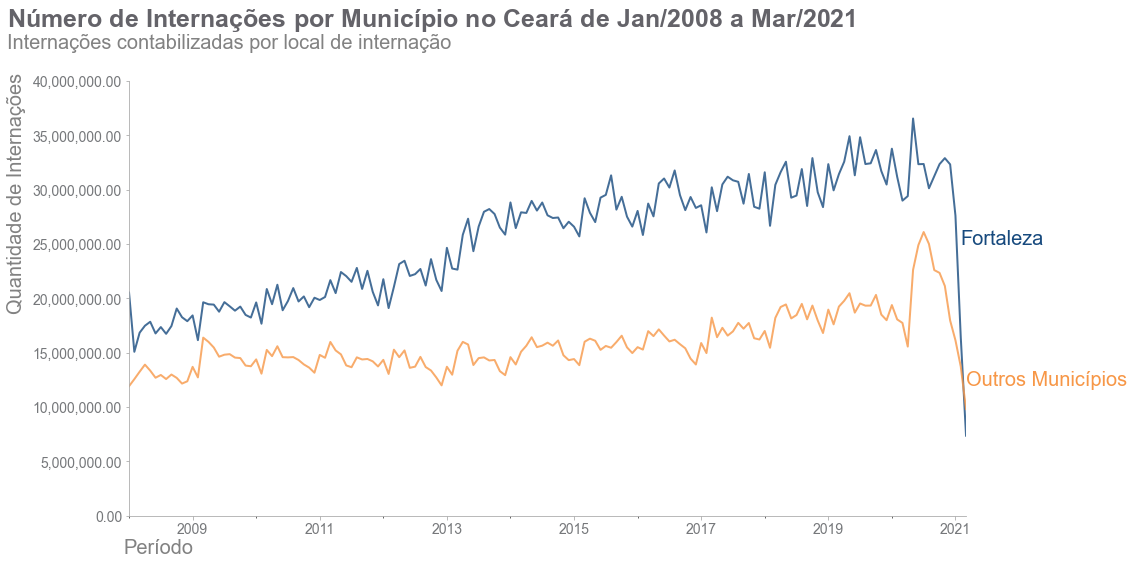

In [238]:
color = [BLUE1, ORANGE1]

ax = valor_total_muni_ce.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 40000001, 5000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(433, 45000000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(433, 43000000, 'Internações contabilizadas por local de internação',
         fontsize = 20, color = GRAY6)

plt.text(433, 19000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -3500000, 'Período', fontsize = 20, color = GRAY6)

plt.text(613, 25000000, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(614, 12000000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

Conclusão: Fortaleza gasta mais com menos internações.